https://youtu.be/R-N-YXzvOmY

**Training Detectron2 for Nuclei segmentation in H&E-Stained Images** <br>

Train custom instance segmentation model using Detectron2 - on your own dataset.

<p>

This is part 1 of the two part tutorial on training custom nuclei model where we use Detectron2 (Mask R-CNN) for instance segmentation. Next part will use YOLOv8 for the same task.

<p>

This code is a complete project, with the following steps <br>

* Training Detectron2 model
* Verifying the training metrics and making sense of the numbers
* Testing the trained model on test dataset
* Extracting morphological measurements from the detected objects
* Plotting results

<p>

But first make sure you get your data ready for training. Please watch my video tutorial associated with this code to learn about downloading labeled masks and converting them to COCO JSON format.

<p>

**Nuclei dataset can be downloaded from:** https://www.kaggle.com/datasets/ipateam/nuinsseg?resource=download
<br>

**Dataset description:** https://arxiv.org/abs/2308.01760
<br>
<p>

**Summary of the dataset:** <p>
The NuInsSeg dataset contains more than *30k manually segmented nuclei from 31 human and mouse organs and 665 image patches extracted from H&E-stained whole slide images*. We also provide ambiguous area masks for the entire dataset to show in which areas manual semantic/instance segmentation were impossible.
<p>

**Human organs:**

cerebellum, cerebrum (brain), colon (rectum), epiglottis, jejunum, kidney, liver, lung, melanoma, muscle, oesophagus, palatine tonsil, pancreas, peritoneum, placenta, salivary gland, spleen, stomach (cardia), stomach (pylorus), testis, tongue, umbilical cord, and urinary bladder
<p>

**Mouse organs:**

cerebellum, cerebrum, colon, epiglottis, lung, melanoma, muscle, peritoneum, stomach (cardia), stomach (pylorus), testis, umbilical cord, and urinary bladder)

**Install Detectron2**

In [1]:
#!python -m pip install pyyaml==5.1
!pip install "cython<3.0.0" && pip install --no-build-isolation pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone https://github.com/facebookresearch/detectron2
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

fatal: destination path 'detectron2' already exists and is not an empty directory.
������ ������ ã�� �� �����ϴ�.


Verify the torch and detectron versions

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Fri_Nov__3_17:51:05_Pacific_Daylight_Time_2023
Cuda compilation tools, release 12.3, V12.3.103
Build cuda_12.3.r12.3/compiler.33492891_0
torch:  2.3 ; cuda:  cu121
detectron2: 0.6


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(1)
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 1
Count of using GPUs: 4


Import the required libraries

In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from matplotlib import pyplot as plt
from tqdm import tqdm

matplotlib data path: c:\Users\hjkwak\anaconda3\envs\pt-base\lib\site-packages\matplotlib\mpl-data
CONFIGDIR=C:\Users\hjkwak\.matplotlib
interactive is False
platform is win32
CACHEDIR=C:\Users\hjkwak\.matplotlib
Using fontManager instance from C:\Users\hjkwak\.matplotlib\fontlist-v330.json


Register datasets in the COCO format. Let us register both the training and validation datasets. Please note that we are working with training (and validation) data that is is the COCO format where we have a single JSON file that describes all the annotations from all training images. <p>
Here, we are naming our training data as 'dataset_train' and the validation data as 'dataset_val'. Let us handle the test dataset later.



In [5]:
# show current DatasetCatalog
print(DatasetCatalog)

DatasetCatalog(registered datasets: coco_2014_train, coco_2014_val, coco_2014_minival, coco_2014_valminusminival, coco_2017_train, coco_2017_val, coco_2017_test, coco_2017_test-dev, coco_2017_val_100, keypoints_coco_2014_train, keypoints_coco_2014_val, keypoints_coco_2014_minival, keypoints_coco_2014_valminusminival, keypoints_coco_2017_train, keypoints_coco_2017_val, keypoints_coco_2017_val_100, coco_2017_train_panoptic_separated, coco_2017_train_panoptic_stuffonly, coco_2017_train_panoptic, coco_2017_val_panoptic_separated, coco_2017_val_panoptic_stuffonly, coco_2017_val_panoptic, coco_2017_val_100_panoptic_separated, coco_2017_val_100_panoptic_stuffonly, coco_2017_val_100_panoptic, lvis_v1_train, lvis_v1_val, lvis_v1_test_dev, lvis_v1_test_challenge, lvis_v0.5_train, lvis_v0.5_val, lvis_v0.5_val_rand_100, lvis_v0.5_test, lvis_v0.5_train_cocofied, lvis_v0.5_val_cocofied, cityscapes_fine_instance_seg_train, cityscapes_fine_sem_seg_train, cityscapes_fine_instance_seg_val, cityscapes_fi

In [6]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("dataset_train",
                        {},
                        "D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/train/coco_annotations.json",
                        "D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/train"
                        )

register_coco_instances("dataset_val",
                        {},
                        "D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/val/coco_annotations.json", 
                        "D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/val"
                        )

register_coco_instances("dataset_test", 
                        {}, 
                        "D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/test/coco_annotations.json", 
                        "D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/test"
                        )



Let us extract the metadata and dataset dictionaries for both training and validation datasets. These can be used later for other purposes, like visualization, model training, evaluation, etc. We will see a visualization example right away.

In [7]:
train_metadata = MetadataCatalog.get("dataset_train")
train_dataset_dicts = DatasetCatalog.get("dataset_train")

val_metadata = MetadataCatalog.get("dataset_val")
val_dataset_dicts = DatasetCatalog.get("dataset_val")

test_metadata = MetadataCatalog.get("dataset_test")
test_dataset_dicts = DatasetCatalog.get("dataset_test")

[05/08 19:46:59 d2.data.datasets.coco]: Loading D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/train/coco_annotations.json takes 2.45 seconds.
[05/08 19:46:59 d2.data.datasets.coco]: Loaded 976 images in COCO format from D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/train/coco_annotations.json
[05/08 19:47:01 d2.data.datasets.coco]: Loaded 280 images in COCO format from D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/val/coco_annotations.json
[05/08 19:47:02 d2.data.datasets.coco]: Loaded 139 images in COCO format from D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/test/coco_annotations.json


Visualize some random images - Sanity check

In [ ]:
# # Visualize some random samples
# import matplotlib.pyplot as plt
# import logging

# plt.rcParams['figure.figsize'] = [10, 5]
# logging.getLogger('matplotlib').setLevel(logging.WARNING)

# for d in random.sample(train_dataset_dicts, 2):
#     img = cv2.imread(d["file_name"])
#     visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
#     vis = visualizer.draw_dataset_dict(d)
#     plt.imshow(vis.get_image()[:, :, ::-1])
#     plt.show()

# Train <p>
Now we are ready to train a Mask R-CNN model using the Detectron2 library. We start by setting up a configuration file (.cfg) for the model. The configuration file contains many details including the output directory path, training dataset information, pre-trained weights, base learning rate, maximum number of iterations, etc.

In [13]:
# from detectron2.engine import DefaultTrainer

# cfg = get_cfg()
# cfg.OUTPUT_DIR = "D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/models/Detectron2_Models"
# cfg.merge_from_file(model_zoo.get_config_file(
#     "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
#     ))
# cfg.DATASETS.TRAIN = ("dataset_train",)
# cfg.DATASETS.TEST = ("dataset_val",)
# cfg.DATALOADER.NUM_WORKERS = 2
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
#     "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
#     )  # Let training initialize from model zoo
# cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
# cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
# cfg.SOLVER.MAX_ITER = 15000
# cfg.SOLVER.STEPS = []        # do not decay learning rate
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # Default is 512, using 256 for this dataset.
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # We have 1 classes. (Nuclei)
# # NOTE: this config means the number of classes, without the background. Do not use num_classes+1 here.

# os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given congiguration
# trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available


[05/08 18:36:25 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

Start the training

In [20]:
# trainer.train() #Start the training process

[05/08 14:35:26 d2.engine.train_loop]: Starting training from iteration 0


c:\Users\hjkwak\anaconda3\envs\pt-base\lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[05/08 14:35:35 d2.utils.events]:  eta: 0:36:44  iter: 19  total_loss: 8.193  loss_cls: 0.6495  loss_box_reg: 0.1064  loss_mask: 0.6935  loss_rpn_cls: 6.057  loss_rpn_loc: 0.6493    time: 0.1664  last_time: 0.1462  data_time: 0.1704  last_data_time: 0.0016   lr: 4.9953e-06  max_mem: 4857M
[05/08 14:35:38 d2.utils.events]:  eta: 0:35:22  iter: 39  total_loss: 6.271  loss_cls: 0.6569  loss_box_reg: 0.1941  loss_mask: 0.6912  loss_rpn_cls: 4.066  loss_rpn_loc: 0.6543    time: 0.1512  last_time: 0.1488  data_time: 0.0028  last_data_time: 0.0032   lr: 9.9902e-06  max_mem: 4857M
[05/08 14:35:41 d2.utils.events]:  eta: 0:34:53  iter: 59  total_loss: 3.645  loss_cls: 0.6259  loss_box_reg: 0.2897  loss_mask: 0.686  loss_rpn_cls: 1.453  loss_rpn_loc: 0.5615    time: 0.1519  last_time: 0.1460  data_time: 0.0036  last_data_time: 0.0025   lr: 1.4985e-05  max_mem: 5438M
[05/08 14:35:43 d2.utils.events]:  eta: 0:34:07  iter: 79  total_loss: 2.662  loss_cls: 0.5752  loss_box_reg: 0.3481  loss_mask: 0.

Checkout training metrics using tensorboard

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
# %reload_ext tensorboard  #Reload in case you have already loaded it once

%tensorboard --logdir D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/models/Detectron2_Models --port 6007


Save the model and yaml file for future use.

In [ ]:
# import yaml
# import os
# # Save the configuration to a config.yaml file
# config_yaml_path = "D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/models/Detectron2_Models/Lizard_config-15k_iter.yaml"
# with open(config_yaml_path, 'w') as file:
#     yaml.dump(cfg, file)

# #Save the model weights with a different name so we don't accidentally overwrite our model.
# os.rename(os.path.join(cfg.OUTPUT_DIR, "model_final.pth"), os.path.join(cfg.OUTPUT_DIR, "Lizard_15k_iter.pth"))

Optimize Hyper Parameters

In [14]:
from detectron2.engine import DefaultTrainer
import optuna
import yaml
import os
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader


# Define the objective function to optimize
def objective(trial):
    # Sample hyperparameters to try
    ims_per_batch = trial.suggest_categorical("ims_per_batch", [1, 2, 4, 8])
    base_lr = trial.suggest_loguniform("base_lr", 1e-5, 1e-3)
    max_iter = trial.suggest_int("max_iter", 1000, 20000)
    batch_size_per_image = trial.suggest_categorical("batch_size_per_image", [128, 256, 512, 1024])
    
    
    cfg = get_cfg()
    cfg.OUTPUT_DIR = "D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/models/Detectron2_Models"
    cfg.merge_from_file(model_zoo.get_config_file(
        "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
        ))
    cfg.DATASETS.TRAIN = ("dataset_train",)
    cfg.DATASETS.TEST = ("dataset_val",)
    cfg.DATALOADER.NUM_WORKERS = 16
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
        "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
        )  # Let training initialize from model zoo
    cfg.SOLVER.IMS_PER_BATCH = ims_per_batch
    cfg.SOLVER.BASE_LR = base_lr
    cfg.SOLVER.MAX_ITER = max_iter
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = batch_size_per_image

    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # We have 1 classes. (Nuclei)
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    
    # Create an instance of DefaultTrainer with the given configuration
    trainer = DefaultTrainer(cfg)
    trainer.resume_or_load(resume=False)
    
    # Start the training process
    trainer.train()
    
    # Evaluate the model
    evaluator = COCOEvaluator("dataset_val", cfg, False, output_dir=cfg.OUTPUT_DIR)
    val_loader = build_detection_test_loader(cfg, "dataset_val")
    val_results = inference_on_dataset(trainer.model, val_loader, evaluator)

    # Get Average Precision (AP)
    ap = val_results["bbox"]["AP"]

    return ap


# Perform hyperparameter optimization using Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)

# Get the best hyperparameters
best_params = study.best_params
best_ims_per_batch = best_params["ims_per_batch"]
best_lr = best_params["base_lr"]
best_iter = best_params["max_iter"]
best_batch_size = best_params["batch_size_per_image"]

# Save the best hyperparameters to a YAML file
best_hyperparameters_path = "D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/models/Detectron2_Models/best_hyperparameters.yaml"
with open(best_hyperparameters_path, 'w') as file:
    yaml.dump(best_params, file)

# Print the best hyperparameters
print("Best Hyperparameters:")
print(f"Batch Size: {best_ims_per_batch}")
print(f"Learning Rate: {best_lr}")
print(f"Max Iterations: {best_iter}")
print(f"Batch Size per Image: {best_batch_size}")


[I 2024-05-08 20:13:08,846] A new study created in memory with name: no-name-2ca1ef22-3618-456f-8c5c-a5c0803a2caa
C:\Users\hjkwak\AppData\Local\Temp\ipykernel_44100\506191183.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  base_lr = trial.suggest_loguniform("base_lr", 1e-5, 1e-3)


[05/08 20:13:09 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[05/08 20:13:24 d2.engine.train_loop]: Starting training from iteration 0


d:\hjkwak\PROJ_Nuclei_Segmentation\Lizard_Dataset\detectron2\detectron2\layers\wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
d:\hjkwak\PROJ_Nuclei_Segmentation\Lizard_Dataset\detectron2\detectron2\layers\wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(


[05/08 20:13:34 d2.utils.events]:  eta: 0:05:01  iter: 19  total_loss: 8.53  loss_cls: 0.689  loss_box_reg: 0.08105  loss_mask: 0.6933  loss_rpn_cls: 6.286  loss_rpn_loc: 0.7001    time: 0.3066  last_time: 0.2338  data_time: 0.1745  last_data_time: 0.0172   lr: 3.0121e-06  max_mem: 11613M
[05/08 20:13:41 d2.utils.events]:  eta: 0:05:00  iter: 39  total_loss: 6.804  loss_cls: 0.6572  loss_box_reg: 0.1599  loss_mask: 0.6918  loss_rpn_cls: 4.692  loss_rpn_loc: 0.6328    time: 0.3182  last_time: 0.2345  data_time: 0.0220  last_data_time: 0.0138   lr: 6.0241e-06  max_mem: 11613M
[05/08 20:13:46 d2.utils.events]:  eta: 0:04:47  iter: 59  total_loss: 4.545  loss_cls: 0.6107  loss_box_reg: 0.2416  loss_mask: 0.6883  loss_rpn_cls: 2.416  loss_rpn_loc: 0.5987    time: 0.2984  last_time: 0.2759  data_time: 0.0176  last_data_time: 0.0160   lr: 9.036e-06  max_mem: 11613M
[05/08 20:13:51 d2.utils.events]:  eta: 0:04:40  iter: 79  total_loss: 3.17  loss_cls: 0.5633  loss_box_reg: 0.2649  loss_mask: 0

[I 2024-05-08 20:22:43,588] Trial 0 finished with value: 9.105306488964793 and parameters: {'ims_per_batch': 4, 'base_lr': 0.00015074890204867463, 'max_iter': 1112, 'batch_size_per_image': 512}. Best is trial 0 with value: 9.105306488964793.
C:\Users\hjkwak\AppData\Local\Temp\ipykernel_44100\506191183.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  base_lr = trial.suggest_loguniform("base_lr", 1e-5, 1e-3)


[05/08 20:22:44 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[05/08 20:22:49 d2.engine.train_loop]: Starting training from iteration 0
[05/08 20:23:07 d2.utils.events]:  eta: 1:04:13  iter: 19  total_loss: 8.695  loss_cls: 0.7831  loss_box_reg: 0.07687  loss_mask: 0.6922  loss_rpn_cls: 6.473  loss_rpn_loc: 0.6789    time: 0.7501  last_time: 0.8144  data_time: 0.3198  last_data_time: 0.1639   lr: 4.2299e-07  max_mem: 11786M
[05/08 20:23:22 d2.utils.events]:  eta: 1:05:12  iter: 39  total_loss: 8.395  loss_cls: 0.772  loss_box_reg: 0.08497  loss_mask: 0.6919  loss_rpn_cls: 6.183  loss_rpn_loc: 0.6781    time: 0.7516  last_time: 0.6614  data_time: 0.1562  last_data_time: 0.1053   lr: 8.4596e-07  max_mem: 11842M
[05/08 20:23:37 d2.utils.events]:  eta: 1:04:49  iter: 59  total_loss: 7.903  loss_cls: 0.7632  loss_box_reg: 0.09356  loss_mask: 0.6915  loss_rpn_cls: 5.686  loss_rpn_loc: 0.6851    time: 0.7565  last_time: 1.3997  data_time: 0.1574  last_data_time: 0.2133   lr: 1.2689e-06  max_mem: 11842M
[05/08 20:23:54 d2.utils.events]:  eta: 1:05:21  it

[I 2024-05-08 21:37:02,306] Trial 1 finished with value: 8.834727665833842 and parameters: {'ims_per_batch': 8, 'base_lr': 2.116969256473858e-05, 'max_iter': 5245, 'batch_size_per_image': 1024}. Best is trial 1 with value: 8.834727665833842.
C:\Users\hjkwak\AppData\Local\Temp\ipykernel_44100\506191183.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  base_lr = trial.suggest_loguniform("base_lr", 1e-5, 1e-3)


[05/08 21:37:02 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[05/08 21:37:08 d2.engine.train_loop]: Starting training from iteration 0
[05/08 21:37:14 d2.utils.events]:  eta: 0:33:31  iter: 19  total_loss: 8.846  loss_cls: 0.6659  loss_box_reg: 0.0735  loss_mask: 0.6929  loss_rpn_cls: 6.733  loss_rpn_loc: 0.6928    time: 0.1167  last_time: 0.1154  data_time: 0.1620  last_data_time: 0.0018   lr: 3.407e-07  max_mem: 11882M
[05/08 21:37:16 d2.utils.events]:  eta: 0:32:51  iter: 39  total_loss: 8.322  loss_cls: 0.6553  loss_box_reg: 0.09182  loss_mask: 0.6929  loss_rpn_cls: 6.236  loss_rpn_loc: 0.6609    time: 0.1171  last_time: 0.1122  data_time: 0.0018  last_data_time: 0.0014   lr: 6.8138e-07  max_mem: 11882M
[05/08 21:37:18 d2.utils.events]:  eta: 0:32:06  iter: 59  total_loss: 8.212  loss_cls: 0.6485  loss_box_reg: 0.06997  loss_mask: 0.6926  loss_rpn_cls: 6.125  loss_rpn_loc: 0.6756    time: 0.1135  last_time: 0.1076  data_time: 0.0014  last_data_time: 0.0007   lr: 1.0221e-06  max_mem: 11882M
[05/08 21:37:21 d2.utils.events]:  eta: 0:32:47  ite

[I 2024-05-08 22:14:40,790] Trial 2 finished with value: 9.523250617014721 and parameters: {'ims_per_batch': 1, 'base_lr': 1.705113624146262e-05, 'max_iter': 16641, 'batch_size_per_image': 1024}. Best is trial 1 with value: 8.834727665833842.
C:\Users\hjkwak\AppData\Local\Temp\ipykernel_44100\506191183.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  base_lr = trial.suggest_loguniform("base_lr", 1e-5, 1e-3)


[05/08 22:14:41 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[05/08 22:14:46 d2.engine.train_loop]: Starting training from iteration 0
[05/08 22:14:55 d2.utils.events]:  eta: 0:03:11  iter: 19  total_loss: 8.28  loss_cls: 0.6541  loss_box_reg: 0.0949  loss_mask: 0.689  loss_rpn_cls: 6.201  loss_rpn_loc: 0.6606    time: 0.2200  last_time: 0.1474  data_time: 0.1606  last_data_time: 0.0113   lr: 9.408e-06  max_mem: 11882M
[05/08 22:15:00 d2.utils.events]:  eta: 0:03:13  iter: 39  total_loss: 4.614  loss_cls: 0.6048  loss_box_reg: 0.2168  loss_mask: 0.6851  loss_rpn_cls: 2.609  loss_rpn_loc: 0.6594    time: 0.2502  last_time: 0.1553  data_time: 0.0058  last_data_time: 0.0044   lr: 1.8816e-05  max_mem: 11882M
[05/08 22:15:03 d2.utils.events]:  eta: 0:03:08  iter: 59  total_loss: 2.607  loss_cls: 0.5489  loss_box_reg: 0.2777  loss_mask: 0.6768  loss_rpn_cls: 0.5171  loss_rpn_loc: 0.5384    time: 0.2168  last_time: 0.1661  data_time: 0.0074  last_data_time: 0.0043   lr: 2.8223e-05  max_mem: 11882M
[05/08 22:15:06 d2.utils.events]:  eta: 0:03:02  iter: 

[I 2024-05-08 22:22:46,996] Trial 3 finished with value: 9.20843718556924 and parameters: {'ims_per_batch': 2, 'base_lr': 0.0004708490153527247, 'max_iter': 1296, 'batch_size_per_image': 512}. Best is trial 1 with value: 8.834727665833842.
C:\Users\hjkwak\AppData\Local\Temp\ipykernel_44100\506191183.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  base_lr = trial.suggest_loguniform("base_lr", 1e-5, 1e-3)


[05/08 22:22:47 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[05/08 22:22:52 d2.engine.train_loop]: Starting training from iteration 0
[05/08 22:23:11 d2.utils.events]:  eta: 2:42:56  iter: 19  total_loss: 8.57  loss_cls: 0.6921  loss_box_reg: 0.1048  loss_mask: 0.6919  loss_rpn_cls: 6.423  loss_rpn_loc: 0.6698    time: 0.6278  last_time: 0.6169  data_time: 0.4456  last_data_time: 0.1338   lr: 2.7512e-06  max_mem: 11882M
[05/08 22:23:26 d2.utils.events]:  eta: 2:49:35  iter: 39  total_loss: 7.113  loss_cls: 0.6658  loss_box_reg: 0.1401  loss_mask: 0.6906  loss_rpn_cls: 4.929  loss_rpn_loc: 0.6697    time: 0.6890  last_time: 0.7745  data_time: 0.2172  last_data_time: 0.2529   lr: 5.5023e-06  max_mem: 11882M
[05/08 22:23:39 d2.utils.events]:  eta: 2:48:28  iter: 59  total_loss: 4.884  loss_cls: 0.6311  loss_box_reg: 0.2278  loss_mask: 0.6876  loss_rpn_cls: 2.74  loss_rpn_loc: 0.6315    time: 0.6767  last_time: 0.6122  data_time: 0.1806  last_data_time: 0.1657   lr: 8.2533e-06  max_mem: 11882M
[05/08 22:23:51 d2.utils.events]:  eta: 2:46:28  iter: 

[I 2024-05-09 01:24:00,138] Trial 4 finished with value: 11.171956145022449 and parameters: {'ims_per_batch': 8, 'base_lr': 0.0001376909696764989, 'max_iter': 15487, 'batch_size_per_image': 512}. Best is trial 1 with value: 8.834727665833842.


Best Hyperparameters:
Batch Size: 8
Learning Rate: 2.116969256473858e-05
Max Iterations: 5245
Batch Size per Image: 1024


# Inference & evaluation using the trained model

Update the cfg file to load our trained weights. You can also set the desired threshold for segmentation. Instantiate the predictor object using the config file as input. I've already trained a model for 15k iterations so let us go ahead and load it.
<p>
Note that when we say 'load a model' it refers to update the weights of the model you've already defined (in our case: mask_rcnn_R_50_FPN_3x.yaml)

In [15]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "Lizard_15k_iter.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2   # set a custom threshold
predictor = DefaultPredictor(cfg)

[05/08 18:37:03 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/models/Detectron2_Models\Lizard_15k_iter.pth ...
[Checkpointer] Loading from d:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/models/Detectron2_Models\Lizard_15k_iter.pth ...


**Verify segmentation on random test images** <p>
But first, we need to register our test dataset to coco instances.

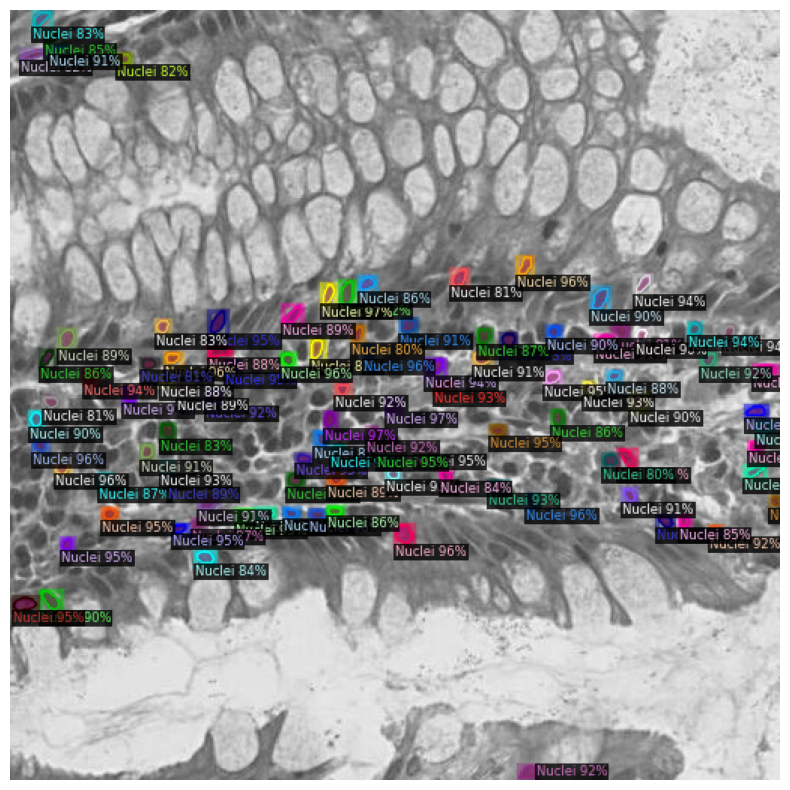

dpath_24_4.png


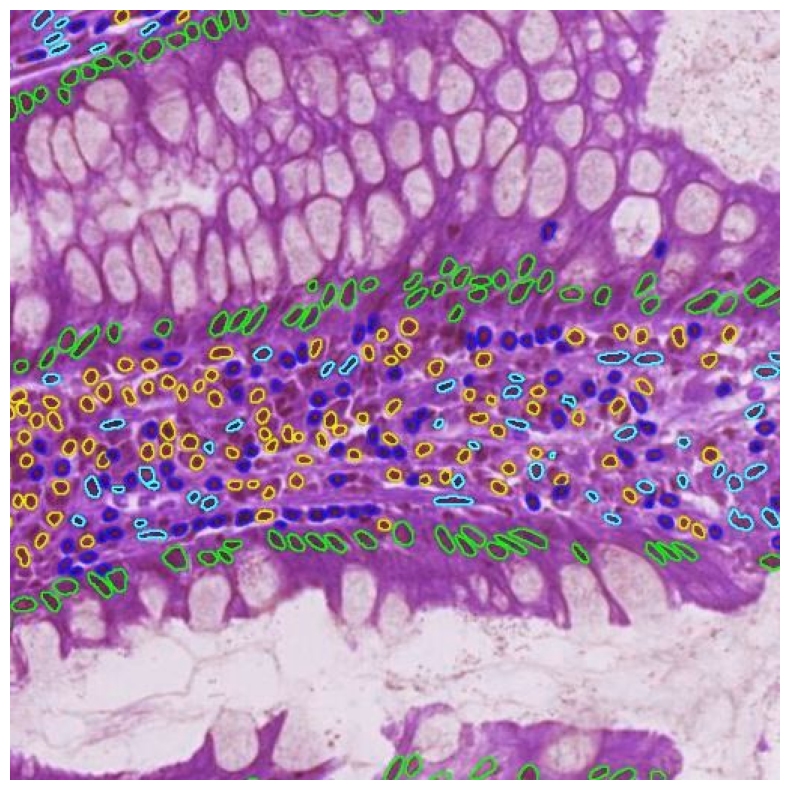

In [20]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(test_dataset_dicts, 1):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata,
                   scale=1,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # cv2_imshow(im[:, :, ::-1])
    # cv2_imshow(out.get_image()[:, :, ::-1])
    
    plt.figure(figsize=(10, 10))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis("off")
    plt.show()

    # compare with the ground truth
    file_name = d["file_name"].split("\\")[-1]
    print(file_name)
    if file_name.endswith(".png"):
        file_name = file_name[:-4] + ".jpg"
    img = cv2.imread(f"D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/overlay/Overlay_patches/{file_name}")
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

You can apply your own threshold to filter objects. But remember that the lowest threshold would be the number set in the cfg setting. Check this line above:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2

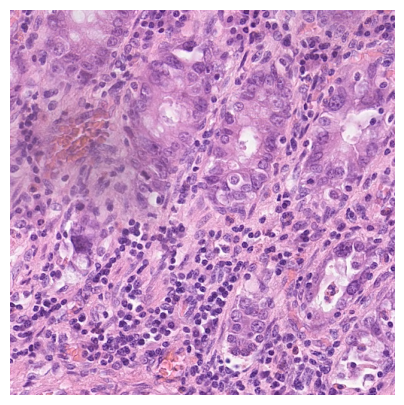

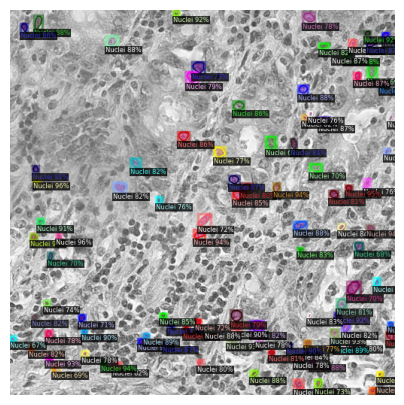

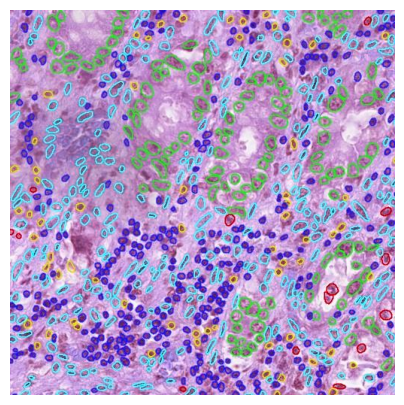

In [21]:
for d in random.sample(test_dataset_dicts, 1):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs2 = predictor(im)

    # Perform prediction on the tile using your trained model
    outputs2 = predictor(im)

# Get the confidence scores
    scores = outputs2["instances"].scores

# Define your custom threshold
    threshold = 0.1

# Filter instances based on confidence threshold
    filtered_indices = [i for i, score in enumerate(scores) if score > threshold]

# Update the instances in the outputs
    outputs2["instances"] = outputs2["instances"][filtered_indices]

    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata,
                   scale=1,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs2["instances"].to("cpu"))

    # cv2_imshow(im[:, :, ::-1])
    # cv2_imshow(out.get_image()[:, :, ::-1])

    plt.figure(figsize=(5, 5))
    plt.imshow(im[:, :, ::-1])
    plt.axis("off")
    plt.show()

    plt.figure(figsize=(5, 5))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis("off")
    plt.show()
    
    # compare with the ground truth
    file_name = d["file_name"].split("\\")[-1]
    if file_name.endswith(".png"):
        file_name = file_name[:-4] + ".jpg"
    img = cv2.imread(f"D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/overlay/Overlay_patches/{file_name}")
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

**Check the segmentation metrics (Average Precision & recall)** <p>
In this example, we have the ground truth masks for our test dataset. If you do not have the ground truth, please use the validation dataset for this part.

In [27]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("dataset_test", output_dir="./output")
test_loader = build_detection_test_loader(cfg, "dataset_test")
print(inference_on_dataset(predictor.model, test_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[05/08 15:11:13 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[05/08 15:11:14 d2.data.datasets.coco]: Loaded 139 images in COCO format from COCO_Dataset/test/coco_annotations.json
[05/08 15:11:15 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   Nuclei   | 39599        |
|            |              |
[05/08 15:11:15 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/08 15:11:15 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/08 15:11:15 d2.data.common]: Serializing 139 elements to byte tensors and concatenating them all ...
[05/08 15:11:15 d2.data.common]: Serialized dataset takes 4.88 MiB
[05/08 15:11:15 d2.evaluation.evaluator]: Start inference on 139 batches
[05/08 15:11:20 d2.evalua

**Understanding the average precision metric:**
<p>

**AP =** Average Precision <br>

**AP50 =** AP calculated using IoU threshold of 0.5. In our case, we got AP50 as 72, which means our model is performing well at this threshold. <br>

**APs (small objects):** Our score is 32 which suggests that the model's performance on small objects is lower than overall performance. <br>

**APm (medium objects):** Our score is 50 suggesting our model performs better on medium objects. <br>

**APl (large objects):** We have NaN. Could mean that we have no large objects.



**Loading a new image and segmenting it.**

In [15]:
new_im = cv2.imread("D:/hjkwak/PROJ_Nuclei_Segmentation/msp-samples/2024-05-03_09_06_48__T02_S04/ScanArea01/0018.jpg")
outputs  = predictor(new_im)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# cv2_imshow(new_im[:, :, ::-1])
# cv2_imshow(out.get_image()[:, :, ::-1])

plt.imshow(new_im[:, :, ::-1])
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.show()

plt.imshow(out.get_image()[:, :, ::-1])
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.show()


NameError: name 'predictor' is not defined

**Processing multiple images in a directory and saving the results in an output directory**

In [26]:
'''
Copy test img files
'''

# import shutil
# import os
# from tqdm import tqdm

# source_images_directory = "D:\hjkwak\PROJ_Nuclei_Segmentation\msp-samples"
# subdirectories = ["2024-05-03_09_06_48__T02_S04", "2024-05-03_09_28_20__T02_S12", "2024-05-03_09_36_00__T02_S14"]

# input_images_directory = "D:\hjkwak\PROJ_Nuclei_Segmentation\msp-samples\input_images"
# # if there is no input_images_directory, create one
# if not os.path.exists(input_images_directory):
#     os.makedirs(input_images_directory)

# cnt = 0

# for subdirectory in tqdm(subdirectories):
#     # go to every folder in the source_images_directory + subdirectory
#     # if image file starts with '0', copy the image to the input_images_directory
#     for root, dirs, files in os.walk(os.path.join(source_images_directory, subdirectory)):
#         for file in files:
#             if file.startswith('0'):
#                 # copy the image to the input_images_directory and rename it
#                 shutil.copy(os.path.join(root, file), os.path.join(input_images_directory, file))
#                 # rename the image file
                
#                 new_file_name = os.path.join(root, file)
#                 new_file_name = '_'.join(new_file_name.split('\\')[-3:])
                
#                 os.rename(os.path.join(input_images_directory, file), os.path.join(input_images_directory, new_file_name))
#                 cnt += 1

# print(cnt)

100%|██████████| 3/3 [00:25<00:00,  8.41s/it]

1676


In [34]:
# check how many files in input_images
print(len(os.listdir("D:\hjkwak\PROJ_Nuclei_Segmentation\msp-samples\input_images")))

1676


In [33]:
print(len(  os.listdir("D:/hjkwak/PROJ_Nuclei_Segmentation/msp-samples/2024-05-03_09_06_48__T02_S04/ScanArea01")
          + os.listdir("D:/hjkwak/PROJ_Nuclei_Segmentation/msp-samples/2024-05-03_09_06_48__T02_S04/ScanArea02")
          + os.listdir("D:/hjkwak/PROJ_Nuclei_Segmentation/msp-samples/2024-05-03_09_06_48__T02_S04/ScanArea03")
          + os.listdir("D:/hjkwak/PROJ_Nuclei_Segmentation/msp-samples/2024-05-03_09_28_20__T02_S12/ScanArea01")
          + os.listdir("D:/hjkwak/PROJ_Nuclei_Segmentation/msp-samples/2024-05-03_09_28_20__T02_S12/ScanArea02")
          + os.listdir("D:/hjkwak/PROJ_Nuclei_Segmentation/msp-samples/2024-05-03_09_36_00__T02_S14/ScanArea01")
          + os.listdir("D:/hjkwak/PROJ_Nuclei_Segmentation/msp-samples/2024-05-03_09_36_00__T02_S14/ScanArea02")          
          )
      - 6*7)

1676


In [23]:
from tqdm import tqdm
import cv2

# Commenting the following code as we often do not need to save segmented images with bounding boxes.
# We need real numbers with object measurements or labeled images as output.


# Directory path to the input images folder
input_images_directory = "D:/hjkwak/PROJ_Nuclei_Segmentation/msp-samples/input_images"

# Output directory where the segmented images will be saved
output_directory = "D:/hjkwak/PROJ_Nuclei_Segmentation/msp-samples/output_images"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# List of valid image extensions
valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif']

# Loop over the images in the input folder
for image_filename in tqdm(os.listdir(input_images_directory)):
    # Check if the file has a valid image extension
    if not any(image_filename.lower().endswith(ext) for ext in valid_extensions):
        continue

    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)

    # Perform prediction on the new image
    outputs = predictor(new_im)

    # We can use `Visualizer` to draw the predictions on the image.
    v = Visualizer(new_im[:, :, ::-1], metadata=test_metadata)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Create the output filename with _result extension
    result_filename = os.path.splitext(image_filename)[0] + "_result.png"
    output_path = os.path.join(output_directory, result_filename)

    # Save the segmented image
    cv2.imwrite(output_path, out.get_image()[:, :, ::-1])

print("Segmentation of all images completed.")

  1%|          | 16/1676 [00:43<1:15:07,  2.72s/it]


KeyboardInterrupt: 


**Segmenting images and saving object level information into a csv file.**




In [ ]:
import csv
from skimage.measure import regionprops, label

In [ ]:
# Assuming you have already defined the 'predictor' object and loaded the model.
# Also, make sure 'metadata' is defined appropriately.

# Directory path to the input images folder
input_images_directory = "/content/drive/MyDrive/ColabNotebooks/data/NuInsSeg_Nuclei_dataset/COCO_dataset/test"

# Output directory where the CSV file will be saved
output_csv_path = "/content/drive/MyDrive/ColabNotebooks/data/NuInsSeg_Nuclei_dataset/COCO_dataset/test_results/output_objects.csv"

# Extract the directory name from the full path
output_dir_name = os.path.dirname(output_csv_path)

# Check if the directory exists
if not os.path.exists(output_dir_name):
    # If not, create the directory
    os.makedirs(output_dir_name)


# List of valid image extensions.
#If you have non-image files (e.g., json) then you don't want to see an error.
#So it is better to define valid file extensions for our task.
valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif']

# Open the CSV file for writing
with open(output_csv_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)

    # Write the header row in the CSV file
    csvwriter.writerow(["File Name", "Class Name", "Object Number", "Area", "Centroid", "BoundingBox"])

    # Loop over the images in the input folder
    for image_filename in os.listdir(input_images_directory):
        # Check if the file has a valid image extension
        if not any(image_filename.lower().endswith(ext) for ext in valid_extensions):
            continue

        image_path = os.path.join(input_images_directory, image_filename)
        new_im = cv2.imread(image_path)

        # Perform prediction on the new image
        outputs = predictor(new_im)

        # Convert the predicted mask to a binary mask
        mask = outputs["instances"].pred_masks.to("cpu").numpy().astype(bool)

        # Get the predicted class labels
        class_labels = outputs["instances"].pred_classes.to("cpu").numpy()

        # Use skimage.measure.regionprops to calculate object parameters
        labeled_mask = label(mask)
        props = regionprops(labeled_mask)

        # Write the object-level information to the CSV file
        for i, prop in enumerate(props):
            object_number = i + 1
            area = prop.area
            centroid = prop.centroid
            bounding_box = prop.bbox

            # Check if the corresponding class label exists
            if i < len(class_labels):
                class_label = class_labels[i]
                class_name = test_metadata.thing_classes[class_label]
            else:
                class_name = 'Unknown'

            csvwriter.writerow([image_filename, class_name, object_number, area, centroid, bounding_box])

print("Object-level information saved to CSV file.")


**Loading our measurements csv file and generating some plots**

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/data/NuInsSeg_Nuclei_dataset/COCO_dataset/test_results/output_objects.csv')


In [ ]:
# 1. Average number of Nuclei per image for each unique 'File Name'.
# Extract the base name from the file name (excluding the number)
df['Base Name'] = df['File Name'].str.rsplit('_', 1).str[0]

# Group by the base name and compute the average number of nuclei
avg_nuclei_per_base_name = df.groupby('Base Name')['Object Number'].mean().reset_index()

plt.figure(figsize=(15, 6))
sns.barplot(data=avg_nuclei_per_base_name, x='Base Name', y='Object Number')
plt.title('Average Number of Nuclei per Image Type')
plt.xticks(rotation=90)
plt.show()


In [ ]:
# 2. Average Nuclei area per unique 'File Name'
# Group by the base name and compute the average area
avg_area_per_base_name = df.groupby('Base Name')['Area'].mean().reset_index()

plt.figure(figsize=(15, 6))
sns.barplot(data=avg_area_per_base_name, x='Base Name', y='Area')
plt.title('Average Nuclei Area per Image Type')
plt.xticks(rotation=90)
plt.show()


In [ ]:
# 3. Distribution of Number of Nuclei by Category (e.g., "human" or "mouse")
df['Category'] = df['File Name'].str.split('_').str[0]

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Category', y='Object Number')
plt.title('Distribution of Number of Nuclei by Category')
plt.show()


In [ ]:
# 4. Average area of Nuclei by Category
avg_area_by_category = df.groupby('Category')['Area'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=avg_area_by_category, x='Category', y='Area')
plt.title('Average Area of Nuclei by Category')
plt.show()

# END

Optional topic - already covered in pevious tutorial - Number 330.

**Saving labeled mask images for each class for further processing.**
<p>
Here, for each input image we will save labeled mask. These masks can be used for further downstream processing.

In [ ]:
import os
import cv2
import numpy as np
from skimage.measure import label
from detectron2.utils.visualizer import Visualizer

# Directory path to the input images folder
input_images_directory = "/content/drive/MyDrive/ColabNotebooks/data/NuInsSeg_Nuclei_dataset/COCO_dataset/test"

# Output directory where the segmented images will be saved
output_directory = "/content/drive/MyDrive/ColabNotebooks/data/NuInsSeg_Nuclei_dataset/COCO_dataset/test_results_labeled_masks"


# Loop over the images in the input folder
for image_filename in os.listdir(input_images_directory):
    # Check if the file has a .png extension
    if not image_filename.lower().endswith('.png'):
        continue

    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)

    # Perform prediction on the new image
    outputs = predictor(new_im)

    # Convert the predicted mask to a binary mask
    binary_mask = outputs["instances"].pred_masks.to("cpu").numpy().astype(np.uint8)

    # Sum along the third dimension to combine all the masks into one
    combined_mask = np.sum(binary_mask, axis=0)

    # Label the combined mask to give each object a unique integer value
    labeled_mask = label(combined_mask)

    # Create the output filename with _result extension
    result_filename = os.path.splitext(image_filename)[0] + "_result.png"
    output_path = os.path.join(output_directory, result_filename)

    # Save the labeled mask
    cv2.imwrite(output_path, labeled_mask.astype(np.uint16))

print("Segmentation of all images completed.")
